In [ ]:
# Installing pyspark in colab
!pip3 install pyspark

     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 198 kB 62.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=e635e3bede2d3d9e6ef29586e3f20b413a7142f7a82795fb3a86a49776251878
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
# create a basic spark session and linking with the sparksession
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Your Group ID").getOrCreate()

In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the data from drive/create a dataframe
IDS_df = spark.read.csv("/content/drive/MyDrive/IDS2018/02-14-2018.csv", header=True, inferSchema =True)

In [ ]:

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import isnan, when, count, col
import time
import functools 
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [ ]:
# Printing the shape and columns of DataFrame
print((IDS_df.count(), len(IDS_df.columns)))
print(IDS_df.columns)

(1048575, 80)
['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate

In [ ]:
# Showing the DataFrame
IDS_df.show()

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+--------------

In [ ]:
# Replacing all special characters from columnNames as its not good practice to have any special characters in a 
#  a column name

import pyspark.sql.functions as F
import re
IDS_df = IDS_df.select([F.col(col).alias(re.sub("[^0-9a-zA-Z$]+","_",col)) for col in IDS_df.columns])
IDS_df.show(10)


+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+--------------

In [ ]:
# This below report display total number of attack in the given file or the dataset /count the total number of attacks by label given in the file or dataset 
IDS_df.select('Label').groupBy('Label').count().orderBy('count', ascending=False).show()

+--------------+------+
|         Label| count|
+--------------+------+
|        Benign|667626|
|FTP-BruteForce|193360|
|SSH-Bruteforce|187589|
+--------------+------+



In [ ]:
#TO CREATE A SQL QUERY WE NEED TO REGISTER THE DATAFRAME AS A SQL TEMPORARY DATAVIEW AND DEFINES THE QUERIES ON THE VIEW
IDS_df.createOrReplaceTempView("DataView")

In [ ]:
# Student usha tamang 2134124
# Query 1 : count the number of attacks by Label where flow duration is greater than zero and protocol is 6 nand tot fwd pkts and tot bwd pkst greater than zero

sqlquery1_bargraph = spark.sql("SELECT Label AS Labelattack1, Count(*) AS Labelattackcount1  FROM (SELECT * FROM DataView WHERE `Flow_Duration` > 0 AND Protocol = 6 AND `Tot_Fwd_Pkts` > 0 AND `Tot_Bwd_Pkts` > 0) GROUP BY Label")
sqlquery1_bargraph.show()

+--------------+-----------------+
|  Labelattack1|Labelattackcount1|
+--------------+-----------------+
|SSH-Bruteforce|           187584|
|        Benign|           320205|
|FTP-BruteForce|           193354|
+--------------+-----------------+



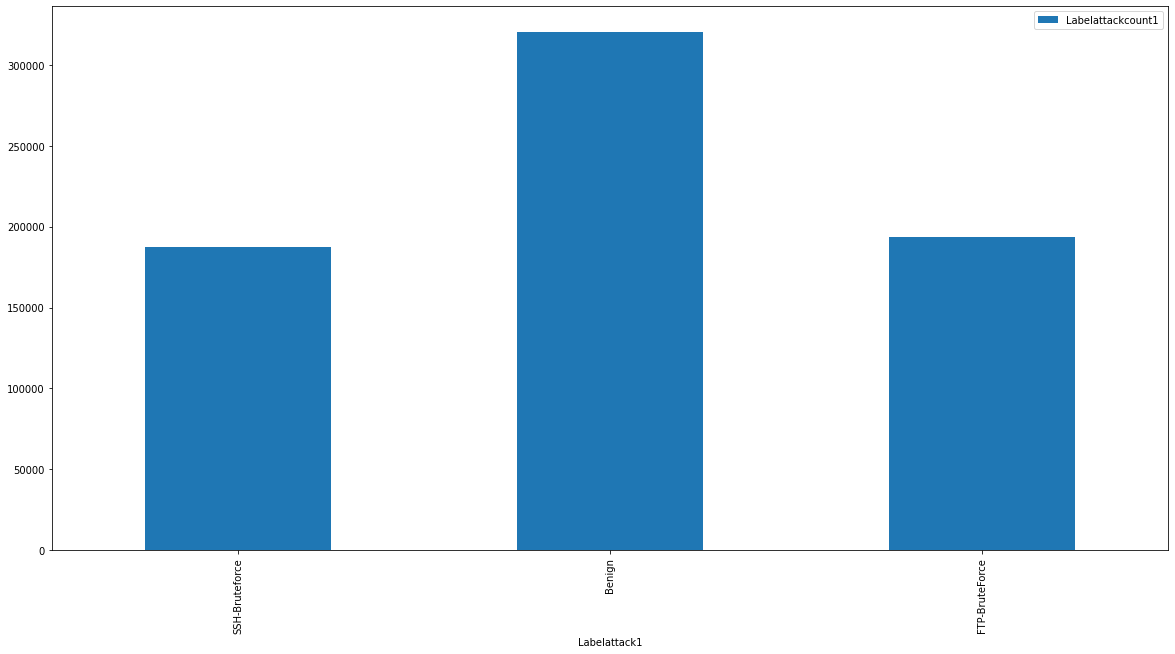

In [ ]:
# plotting the data into bar graph/convert ids_dataframe in to pandas dataframe
# the attacks in the table where protocol is 6 and tot fwd ,flow duration and tot bwd pkts are greater than zero come under the benign attack.
pandas_df1 = sqlquery1_bargraph.toPandas()
pandas_df1.plot(x='Labelattack1', kind = 'bar')


In [ ]:
#  Query : 2 count the number of attacks group by label and the protocol where Flow_IAT_Std and pkt len mean are greater than 0
sqlquery2_graph = spark.sql("SELECT Label As Labelattack2, Protocol as protocolnumber, count(*) AS Labelattackcount2  FROM DataView WHERE `Flow_IAT_Std` > 0 AND `Pkt_Len_Mean` > 0 GROUP BY Label, Protocol")
sqlquery2_graph.show()

+--------------+--------------+-----------------+
|  Labelattack2|protocolnumber|Labelattackcount2|
+--------------+--------------+-----------------+
|        Benign|             6|           283894|
|SSH-Bruteforce|             6|            93818|
|        Benign|            17|            40591|
+--------------+--------------+-----------------+



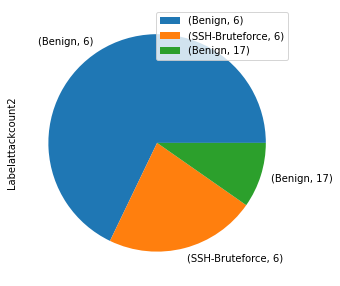

In [ ]:
# # Plotting the data into stacked bar graph
# Interpretation : All SSH-Bruteforce attaks with Flow_IAT_Std greater than 0 and Pkt Len Mean greater than 0 comes under Protocol 6
# Attacks under protocol 17 with Flow_IAT_Std greater than 0 and Pkt Len Mean greater than 0 are definitely Benign

pandas_df2 = sqlquery2_graph.toPandas()
pandas_df2.set_index(['Labelattack2', 'protocolnumber'], inplace=True, drop=True)
pandas_df2.plot.pie(y='Labelattackcount2',figsize=(5,5))


In [ ]:
# anaylytics method part 1 : data analysis using percentile
# by using percentile method we are trying to find out how data are spread over the pth value.

import pyspark.sql.functions as F



IDS_df_20 = IDS_df.groupBy('Label').agg(F.expr('percentile_approx(Subflow_Fwd_Byts,0.20)').alias("20% Percentile"))
IDS_df_50 = IDS_df.groupBy('Label').agg(F.expr('percentile_approx(Subflow_Fwd_Byts,0.50)').alias("50% Percentile"))
IDS_df_75 = IDS_df.groupBy('Label').agg(F.expr('percentile_approx(Subflow_Fwd_Byts,0.75)').alias("75% Percentile"))
IDS_df_90 = IDS_df.groupBy('Label').agg(F.expr('percentile_approx(Subflow_Fwd_Byts,0.90)').alias("90% Percentile"))

IDS_df_20.show()
IDS_df_50.show()
IDS_df_75.show()
IDS_df_90.show()

+--------------+--------------+
|         Label|20% Percentile|
+--------------+--------------+
|SSH-Bruteforce|             0|
|        Benign|             0|
|FTP-BruteForce|             0|
+--------------+--------------+

+--------------+--------------+
|         Label|50% Percentile|
+--------------+--------------+
|SSH-Bruteforce|          1912|
|        Benign|            49|
|FTP-BruteForce|             0|
+--------------+--------------+

+--------------+--------------+
|         Label|75% Percentile|
+--------------+--------------+
|SSH-Bruteforce|          1928|
|        Benign|           455|
|FTP-BruteForce|             0|
+--------------+--------------+

+--------------+--------------+
|         Label|90% Percentile|
+--------------+--------------+
|SSH-Bruteforce|          1944|
|        Benign|          1148|
|FTP-BruteForce|             0|
+--------------+--------------+



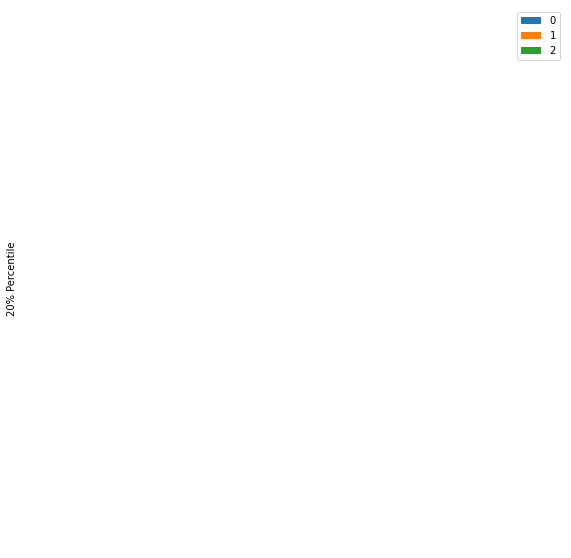

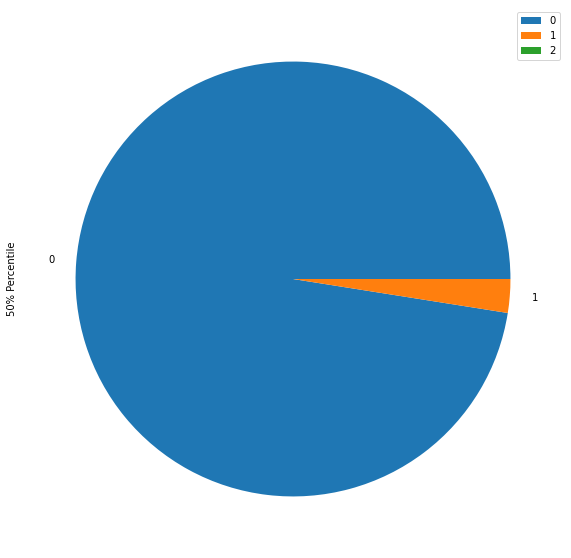

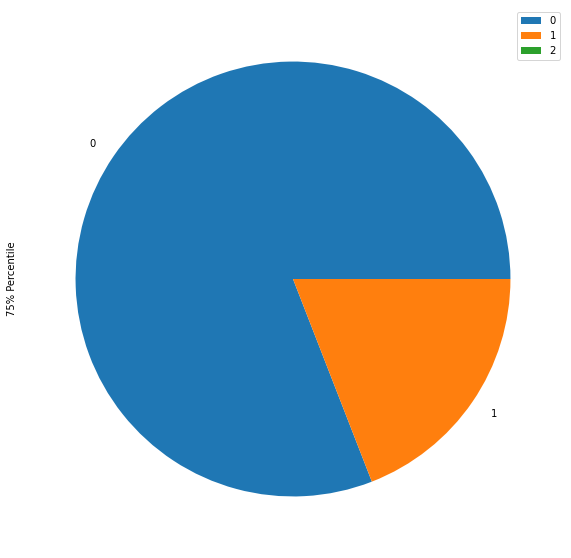

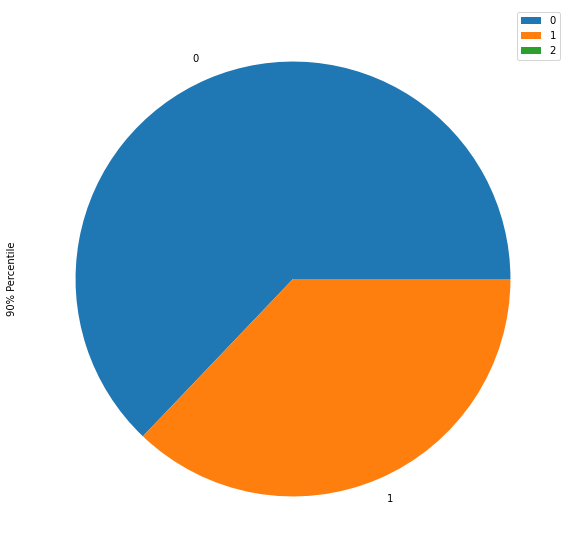

In [ ]:
# graphical represetation of percentile of above data

IDS_df_20.toPandas().plot(y="20% Percentile",kind="pie",x="Label")
IDS_df_50.toPandas().plot(y="50% Percentile",kind="pie",x="Label")
IDS_df_75.toPandas().plot(y="75% Percentile",kind="pie",x="Label")
IDS_df_90.toPandas().plot(y="90% Percentile",kind="pie",x="Label")

In [ ]:
#analytics method part 2: data analyisi using quartiles
#find out the first second and third quartiles and see the distribution of data over these quartiles.
IDS_df_traffic = IDS_df.select('Subflow_Fwd_Byts','Init_Fwd_Win_Byts','Fwd_Act_Data_Pkts').toPandas().quantile([0.25,0.5,0.75])
print(IDS_df_traffic)

      Subflow_Fwd_Byts  Init_Fwd_Win_Byts  Fwd_Act_Data_Pkts
0.25               0.0              241.0                0.0
0.50              36.0             8192.0                0.0
0.75             455.0            26883.0                4.0


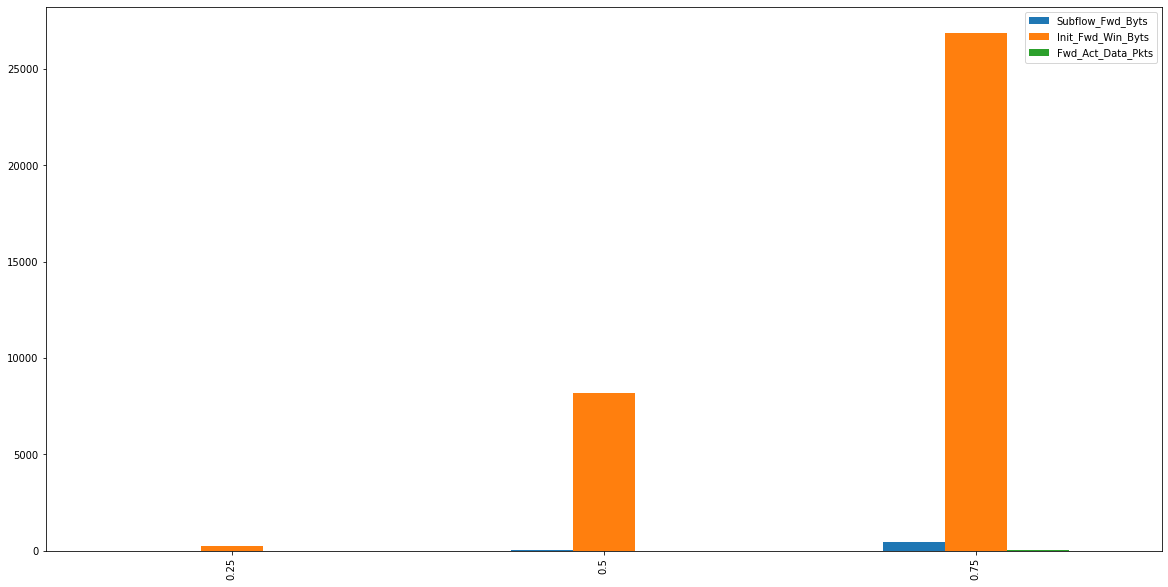

In [ ]:
#graphical representation of above data which is distributed as first, second and third quartiles
IDS_df_traffic.plot(kind="bar",Label ="Quantile")

In [ ]:
# usha tamang 2134124
# Analytical Method 3 : data analysis using skewness and kurtosis
# measure the asymmetry of the data over the mentioned columns
# fwe psh flags column data is  positive so the data are spread out more to the left side
# bwd psh flags,fwd urg flafs, bwd urg flags are zero which means skewness is noraml distrubution(fairly sysmmetrical)
# more positve skewness means more outliers in kurtosis so these two are proportinally dependant to each other.

IDS_df_traffic_skew = IDS_df.select('Fwd_PSH_Flags','Bwd_PSH_Flags','Fwd_URG_Flags','Bwd_URG_Flags').toPandas().skew()
IDS_df_traffic_kurt = IDS_df.select('Fwd_PSH_Flags','Bwd_PSH_Flags','Fwd_URG_Flags','Bwd_URG_Flags').toPandas().kurt()
print(IDS_df_traffic_skew)
print(IDS_df_traffic_kurt)


Fwd_PSH_Flags    5.884694
Bwd_PSH_Flags    0.000000
Fwd_URG_Flags    0.000000
Bwd_URG_Flags    0.000000
dtype: float64
Fwd_PSH_Flags    32.629684
Bwd_PSH_Flags     0.000000
Fwd_URG_Flags     0.000000
Bwd_URG_Flags     0.000000
dtype: float64


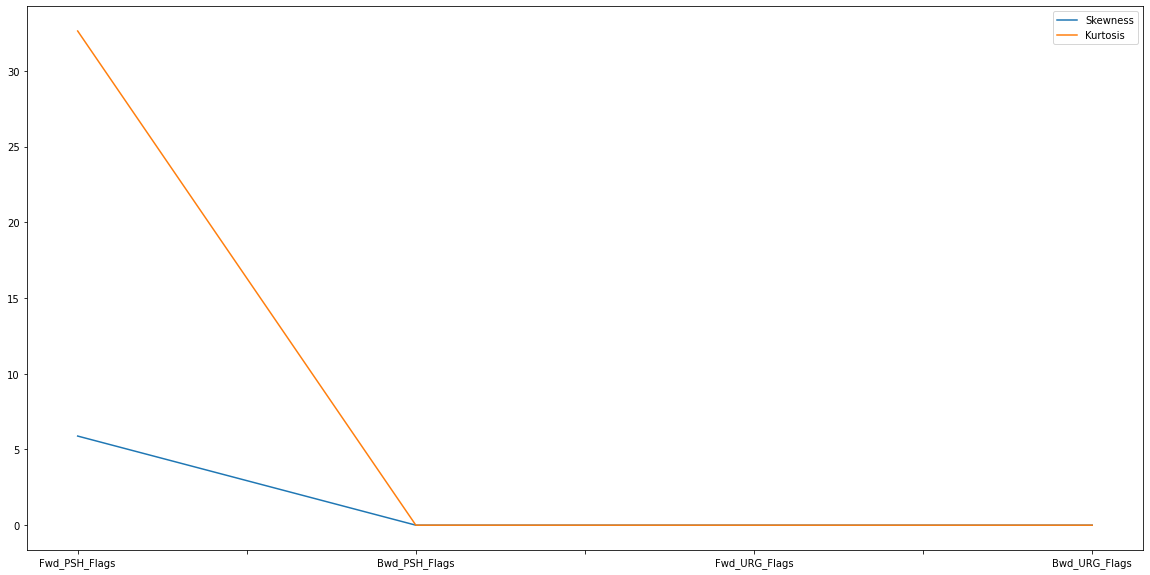

In [ ]:
# graphical represntation of skewness and kurt of the above data in the terms of line
IDS_df_traffic_skew.plot(kind="line",label ="Skewness")
IDS_df_traffic_kurt.plot(kind="line",label ="Kurtosis")
plt.legend()





In [ ]:
# Machine Learning Technique: Classification using Logistic Regression
#using machine learning techniques we are training  the model with provided dataset and testing the model with after splited test data where we can predict the types of label attacks

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

# convert string into number using stringindexer
index_number = StringIndexer(inputCol="Label", outputCol="Label_no", stringOrderType="frequencyDesc")
#converting string into number 
task1 = index_number.setHandleInvalid("skip").fit(IDS_df).transform(IDS_df)
task1.show(5)

# converting all mentioned columns below in to one single column
column_sec = VectorAssembler(inputCols=['FIN_Flag_Cnt','RST_Flag_Cnt','PSH_Flag_Cnt','SYN_Flag_Cnt','ECE_Flag_Cnt','ACK_Flag_Cnt',
                                              'URG_Flag_Cnt','Pkt_Size_Avg','Protocol','Flow_Duration','Tot_Fwd_Pkts','Dst_Port'], outputCol="singlecolumn")



task2 = column_sec.setHandleInvalid("skip").transform(task1)
task2.show(5)
final_result = task2.select("singlecolumn", "Label_no")

train_data, test_data = final_result.randomSplit([0.8,0.2])
#using logisticregression we are predicting the probability of types of attacks based on these two columns singlecolumn and Label_no.
LR = LogisticRegression(featuresCol='singlecolumn', labelCol='Label_no', maxIter=50)
model = LR.fit(train_data)
finalresult_prediction = model.evaluate(test_data)
accuracy = finalresult_prediction.accuracy

print("Accuracy : ", accuracy)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+--------------+------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-